
# Bayesovská regrese cenových odchylek stETH pomocí rizikových faktorů DeFi
# autor: Artem Vitkov
# datum: 22.06.2023


## Instalace a načítání potřebných balíčků

Pro účely analýzy byl v prostředí R použit specifický soubor balíčků, které umožňují provedení bayesovské regrese, pokročilých grafických vizualizací a diagnostických kontrol výsledků. Níže uvedený kód ukazuje jejich instalaci a následné načtení:

In [26]:
install.packages(c(
  'ggthemes', 'brms', 'performance', 'bayesplot', 'rsample',
  'patchwork', 'infotheo', 'mRMRe', 'PerformanceAnalytics',
  'zoo', 'ggcorrplot', 'cmdstanr', 'loo', 'xts'
))

# Instalace CmdStanR (pokud ještě nebyl nainstalován)
if (!require(cmdstanr)) {
  install.packages("cmdstanr",
                   repos = c("https://mc-stan.org/r-packages/",
                             getOption("repos")))
  cmdstanr::install_cmdstan()
}

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Warning message:
“package ‘cmdstanr’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message in install.packages(c("ggthemes", "brms", "performance", "bayesplot", :
“installation of package ‘PerformanceAnalytics’ had non-zero exit status”


Po instalaci jsou balíčky načteny přímo do pracovního prostředí:

In [27]:
knitr::opts_chunk$set(echo = TRUE)
options(mc.cores = parallel::detectCores()) # paralelní výpočet ve Stan

library(tidyverse)              # základní manipulace s daty a vizualizace
library(ggthemes)               # profesionální vzhled grafů (téma Economist)
library(brms)                   # bayesovská inference přes Stan
library(performance)            # výpočet diagnostik (např. VIF, R2)
library(bayesplot)              # kontrola posteriorních distribucí
library(rsample)                # tvorba trénovacích a testovacích sad (rolling-window)
library(patchwork)              # spojování více grafů do jednoho
library(infotheo)               # výpočet vzájemné informace (MI)
library(mRMRe)                  # výběr proměnných metodou mRMR
library(PerformanceAnalytics)   # finanční metriky (např. Sharpeho poměr)
library(zoo)                    # manipulace s časovými řadami (doplnění NA hodnot)
library(ggcorrplot)             # vizualizace korelačních matic
library(cmdstanr)               # efektivní backend pro Stan
library(loo)                    # cross-validace metodou PSIS-LOO
library(xts)                    # práce s časovými řadami (xts formát)

# Nastavení jednotného vizuálního stylu pro všechny grafy
theme_set(theme_economist())

Popis vybraných klíčových balíčků:

1. brms a cmdstanr slouží k efektivnímu výpočtu bayesovských modelů pomocí rozhraní Stan.

2. performance a bayesplot jsou určeny k diagnostice a vizualizaci posteriorních distribucí.

3. ggplot2, ggthemes, patchwork a ggcorrplot umožňují tvorbu pokročilých a přehledných grafických výstupů.

4. rsample usnadňuje rozdělení datových sad pomocí metody rolling-window.

5. infotheo a mRMRe jsou využity při výběru nejvhodnějších prediktorů pomocí vzájemné informace.

6. PerformanceAnalytics, zoo a xts nabízejí pokročilé funkce pro finanční analýzu, výpočet rizikových metrik a práci s časovými řadami.

Nastavení paralelního zpracování (mc.cores) na maximální počet jader urychluje bayesovské výpočty a diagnostiku výsledků.

## Nastavení kompilace CmdStanR

Pro zajištění správného a stabilního běhu Stan modelů na platformách, které mohou mít problémy s paralelní kompilací (např. Google Colab), je vhodné nastavit omezení na jedinou úlohu při kompilaci. Tím se předejde typickým chybám typu „No child processes“.

In [33]:
# FORCE make to use only one job (avoids “No child processes” errors)
Sys.setenv(MAKEFLAGS = "-j1")

## Popis použitých dat

Níže uvádíme seznam datasetů využitých pro analýzu, získaných pomocí Dune Analytics dotazů:

* **AAVE APY DATA UPD (5319271)**: Data od 4. 12. 2020, obsahující `supply_apy`, `variable_borrow_apy`, `stable_borrow_apy`.
* **UNI V3 Liquidity UPD (5319481)**: Data od 4. 5. 2021, zahrnující likviditu v `liquidity_usdc`, `liquidity_weth`, `liquidity_usd`.
* **UNI V2 Liquidity data UPD (5319870)**: Data od 5. 5. 2020, poskytující `total_liquidity`.
* **Lido Staking User APR UPD (5319978)**: Data od 30. 4. 2021, sledující `Lido staking APR(instant)`, `Lido staking APR(ma_7)`, `CL APR`, `EL APR`.
* **ETH average daily funding UPD (5320024)**: Data od 31. 8. 2021, zahrnující `avg_funding_rate_arith`, `avg_funding_rate_geo`.
* **LIDO WETH-STETH liq (5319336)**: Data od 19. 12. 2020, obsahující rezervy a ceny `weth_reserve`, `usdc_reserve`, `weth_price`, `usdc_price`, `trading_volume`.
* **get\_price\_data UPD (5320039)**: Data od 31. 12. 2019, sledující ceny `eth_usd`, `steth_usd`.

**Analyzované období:** 31. 8. 2021 – 21. 8. 2025

Všechna data z výše uvedených zdrojů byla sloučena do jediné ploché tabulky obsahující celkem 20 proměnných, jejichž popis je shrnut v následující tabulce:

| #  | Proměnná                    | Popis                                                                                          |
| -- | --------------------------- | ---------------------------------------------------------------------------------------------- |
| 1  | `evt_block_time`            | Datum (UTC) snapshotu bloku Etherea, ke kterému se vztahují všechny metriky.                   |
| 2  | `supply_apy`                | Roční procentní výnos ze zásobení WETH na platformě Aave v2 v daný okamžik.                    |
| 3  | `variable_borrow_apy`       | Roční úrokové náklady za půjčení WETH na platformě Aave v2 s pohyblivou úrokovou sazbou.       |
| 4  | `stable_borrow_apy`         | Roční úrokové náklady za půjčení WETH na platformě Aave v2 s pevnou úrokovou sazbou.           |
| 5  | `liquidity_usd`             | Denní likvidita Uniswap poolu vyjádřená v USD.                                                 |
| 6  | `liquidity_usdc`            | Část likvidity poolu držena v USDC vyjádřená v jednotkách USDC.                                |
| 7  | `liquidity_weth`            | Část likvidity poolu držena v WETH vyjádřená v jednotkách WETH.                                |
| 8  | `total_liquidity`           | Celková likvidita sledovaného poolu vyjádřená v ekvivalentu USD.                               |
| 9  | `Lido staking APR(instant)` | Okamžitá roční procentní sazba, kterou vyplácí Lido stakerům ETH.                              |
| 10 | `Lido staking APR(ma_7)`    | Sedmidenní klouzavý průměr staking APR platformy Lido, který vyhlazuje krátkodobou volatilitu. |
| 11 | `CL APR`                    | Denní anualizovaný výnos z odměn získaných z Ethereum Consensus-layer.                         |
| 12 | `EL APR`                    | Denní anualizovaný výnos z odměn získaných z Ethereum Execution-layer.                         |
| 13 | `avg_funding_rate_geo`      | Geometrický průměr funding rate pro ETH perpetual futures na platformě GMX-Arbitrum.           |
| 14 | `weth_reserve`              | Počet tokenů WETH uzamčených v Uniswap likviditním poolu k danému okamžiku.                    |
| 15 | `usdc_reserve`              | Počet tokenů USDC uzamčených v Uniswap likviditním poolu k danému okamžiku.                    |
| 16 | `weth_price`                | Cena WETH v USD získaná z on-chain cenových feedů.                                             |
| 17 | `usdc_price`                | Cena USDC v USD sloužící k ověření stability kurzu vůči dolaru.                                |
| 18 | `trading_volume`            | Celkový denní objem obchodů v daném Uniswap poolu.                                             |
| 19 | `eth_usd`                   | Denní průměrná spotová cena ETH vůči USD z on-chain oráklů.                                    |
| 20 | `steth_usd`                 | Denní cena staked ETH tokenu (stETH) v USD, využívaná pro analýzu odchylek.                    |


## Načtení a základní kontrola dat

V této sekci jsou data načtena ze souboru `merged_data.csv` pomocí balíčku `readr` a funkce `read_csv`. Zároveň je provedena kontrola správnosti typů jednotlivých proměnných.

In [37]:
# Načtení datasetu
data_raw <- read_csv("merged_data.csv",
                     col_types = cols(.default = col_double(),
                                      evt_block_time = col_date()))

# Kontrola struktury datasetu
glimpse(data_raw)

Rows: 1,391
Columns: 20
$ evt_block_time              <date> 2021-08-31, 2021-09-01, 2021-09-02, 2021-…
$ supply_apy                  <dbl> 0.023024993, 0.022828568, 0.022934094, 0.0…
$ variable_borrow_apy         <dbl> 0.5443695, 0.5418836, 0.5431943, 0.5422138…
$ stable_borrow_apy           <dbl> 3.680462, 3.677355, 3.678993, 3.677767, 3.…
$ liquidity_usd               <dbl> 586109350, 399200660, 509803085, 771446330…
$ liquidity_usdc              <dbl> 121747468, 143711780, 158957143, 215780909…
$ liquidity_weth              <dbl> 141008.38, 71722.42, 92874.20, 142694.96, …
$ total_liquidity             <dbl> -0.03265494, -0.22160671, -0.22442877, -0.…
$ `Lido staking APR(instant)` <dbl> 0.04949539, 0.04921020, 0.04937743, 0.0500…
$ `Lido staking APR(ma_7)`    <dbl> 0.04986689, 0.04969531, 0.04947401, 0.0495…
$ `CL APR`                    <dbl> 4.950, 4.921, 4.938, 5.005, 5.161, 5.226, …
$ `EL APR`                    <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, …
$ avg_funding_ra

### Počet řádků: 1391 a počet sloupců: 20

## Příprava cílové proměnné pro analýzu

V rámci analýzy se zaměřujeme na relativní denní výnosy (logaritmické změny cen) tokenu stETH vůči USD. Tato proměnná slouží jako cílová veličina (`target_dev`) v následné bayesovské regresní analýze.

In [39]:
# Ověření existence klíčové proměnné 'steth_usd'
stopifnot("steth_usd" %in% names(data_raw))

# Výpočet cílové proměnné (logaritmická změna ceny stETH)
data <- data_raw %>%
  arrange(evt_block_time) %>%                          # seřazení podle času
  mutate(
    target_dev = log(steth_usd) - lag(log(steth_usd))  # výpočet denních výnosů
  ) %>%
  drop_na(target_dev)                                  # odstranění prvního řádku s hodnotou NA po posunu

## Agregace likvidity a transformace proměnných

V této fázi provádíme agregaci likviditních ukazatelů Uniswap V2 a V3 do jediné společné proměnné `uniswap_liquidity`. Zároveň provádíme úpravu dalších klíčových ukazatelů (`usdc_depeg_bp` a `steth_premium`

In [40]:
# Kombinace Uniswap V2 a V3 likvidity do jedné proměnné
data <- data %>%
  mutate(
    uniswap_liquidity = rowSums(select(., liquidity_usdc, liquidity_weth,
                                           weth_reserve, usdc_reserve),
                                na.rm = TRUE)
  )

# Výpočet nových proměnných: odchylka USDC od parity v bazických bodech a prémium stETH vůči ETH
data <- data %>%
  mutate(
    usdc_depeg_bp = (usdc_price - 1) * 1e4,   # Odchylka USDC od $1.00 v bazických bodech
    steth_premium = steth_usd / eth_usd - 1   # Prémium nebo diskont ceny stETH vůči ETH
  )

# Odstranění původních likviditních proměnných, které byly sloučeny
drop.cols <- c('liquidity_usdc', 'liquidity_weth', 'weth_reserve', 'usdc_reserve')
data <- data %>% select(-one_of(drop.cols))

# Přejmenování sloupců pro lepší manipulaci v R
data <- data %>%
  rename(
    Lido_staking_APR_instant = `Lido staking APR(instant)`,
    Lido_staking_APR_ma_7 = `Lido staking APR(ma_7)`,
    CL_APR = `CL APR`,
    EL_APR = `EL APR`
  )

## Vizualizace chybějících hodnot v datech

Pro kontrolu kvality dat a posouzení vhodnosti prediktorů pro další analýzu je důležité zjistit počet chybějících hodnot v každé proměnné. Následující kód generuje přehledný sloupcový graf, který zobrazuje počet chybějících hodnot pro každou proměnnou:

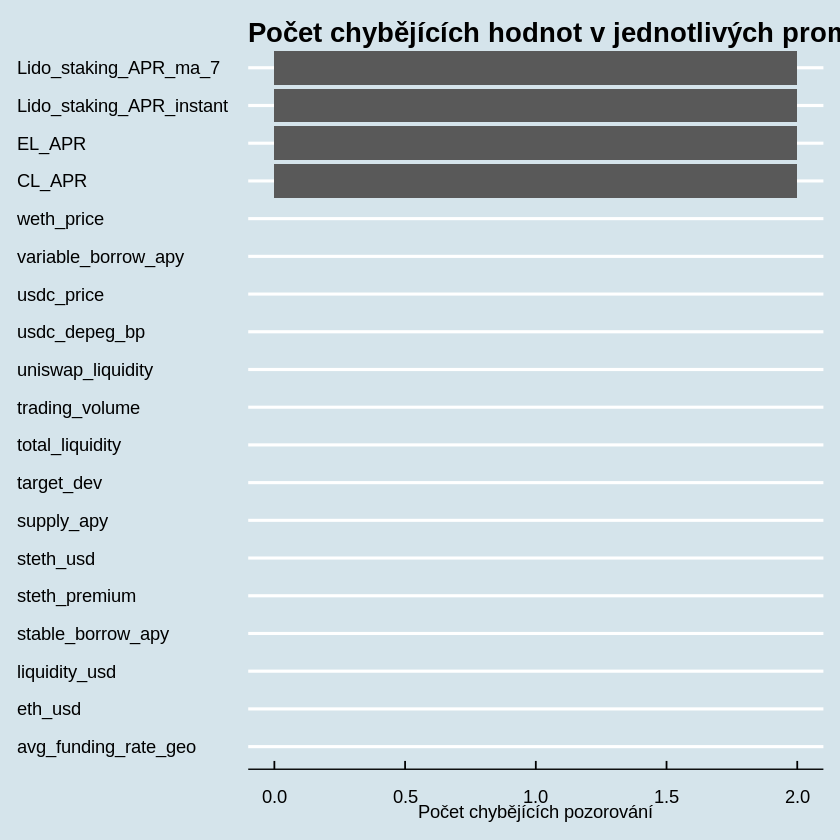

In [42]:
data %>%
  select(-evt_block_time) %>%          # sloupec s datem nepotřebujeme
  is.na() %>%                          # identifikace chybějících hodnot
  colSums() %>%                        # součet chybějících hodnot v každém sloupci
  enframe(name = "promenna", value = "pocet_chybejicich") %>%  # převod do tabulky
  ggplot(aes(reorder(promenna, pocet_chybejicich), pocet_chybejicich)) +
  geom_col() +
  coord_flip() +
  labs(title = "Počet chybějících hodnot v jednotlivých proměnných",
       x = NULL,
       y = "Počet chybějících pozorování")

## Analýza a doplnění chybějících hodnot (forward fill)

U vybraných proměnných jsme identifikovali malý počet chybějících hodnot. Konkrétně se jedná o:

In [43]:
colSums(is.na(data[c("Lido_staking_APR_instant", "Lido_staking_APR_ma_7",
                     "CL_APR", "EL_APR")]))

Lido_staking_APR_instant    Lido_staking_APR_ma_7                   CL_APR 
                       2                        2                        2 
                  EL_APR 
                       2

Výsledkem jsou vždy 2 chybějící hodnoty pro každou z těchto proměnných, které se vyskytují ve dnech:

In [44]:
data %>%
  filter(if_any(c("Lido_staking_APR_instant", "Lido_staking_APR_ma_7",
                  "CL_APR", "EL_APR"), is.na)) %>%
  select(evt_block_time)

evt_block_time
<date>
2022-11-09
2022-11-11



Jde o data ze dnů 9. listopadu 2022 a 11. listopadu 2022. (Jedná se o výpadek dat, který je spojený s bankrotem burzy FTX)

K doplnění těchto chybějících hodnot používáme metodu forward fill, která zachovává poslední dostupnou hodnotu do okamžiku, kdy je k dispozici nové pozorování.

In [46]:
data <- data %>%
  arrange(evt_block_time) %>%
  mutate(across(c("Lido_staking_APR_instant",
                  "Lido_staking_APR_ma_7",
                  "CL_APR",
                  "EL_APR"),
                ~ zoo::na.locf(.x, na.rm = FALSE)))

Tato metoda je vhodná, protože počet chybějících hodnot je velmi malý a neměla by významně zkreslit výsledky další analýzy.

## Výběr proměnných metodou Mutual Information (mRMR)

Pro výběr nejvhodnějších prediktorů byla použita metoda **minimum-Redundancy–Maximum-Relevance (mRMR)** založená na vzájemné informaci (Mutual Information - MI). Cílem této metody je najít proměnné, které mají vysokou informační hodnotu vůči cílové proměnné a zároveň minimální vzájemnou redundanci.

In [47]:
# 1. Příprava kandidátních prediktorů (numerické proměnné)
pred_pool <- data %>%
  select(-evt_block_time, -target_dev) %>%   # odstranění času a cílové proměnné
  select(where(is.numeric))                  # ponechání pouze numerických prediktorů

# 2. Výběr proměnných pomocí mRMR
set.seed(6945)
mrmr_data <- mRMRe::mRMR.data(
  data = data.frame(scale(cbind(target_dev = data$target_dev, pred_pool)))
)

mrmr_sel <- mRMRe::mRMR.classic(
  data = mrmr_data,
  target_indices = 1,          # první sloupec je cílová proměnná (target_dev)
  feature_count = 15           # výběr 15 nejlepších proměnných (lze upravit dle potřeby)
)

# Získání vybraných proměnných
mi_selected <- solutions(mrmr_sel)[[1]]
predictor_vars <- featureNames(mrmr_data)[mi_selected]


### Odůvodnění výběru a úpravy proměnných

| Skupina             | Ponechané proměnné                 | Vyřazené / sloučené proměnné                                       | Zdůvodnění výběru                                                                                             |
| ------------------- | ---------------------------------- | ------------------------------------------------------------------ | ------------------------------------------------------------------------------------------------------------- |
| **APR (staking)**   | `Lido_staking_APR_ma_7`            | `Lido_staking_APR_instant`                                         | 7denní klouzavý průměr redukuje krátkodobý šum; instantní APR má vysokou kolinearitu (VIF ≈ 98).              |
| **CL / EL odměny**  | `CL_APR`                           | `EL_APR`                                                           | CL a EL se pohybují téměř totožně (VIF ≈ 6); CL\_APR má vyšší ekonomickou relevanci a silnější MI.            |
| **Výnosy WETH/ETH** | vypuštěno (`steth_ret`, `eth_ret`) | —                                                                  | Zahrnutí výnosů ETH/stETH by vedlo k rekonstrukci cílové proměnné v prediktorech (VIF > 80).                  |
| **Aave sazby**      | `supply_apy`                       | `variable_borrow_apy`, `stable_borrow_apy`                         | Supply APY zachycuje poptávku po půjčování; půjčovací sazby vykazují téměř lineární závislost (VIF > 70).     |
| **Likvidita**       | `uniswap_liquidity`                | `liquidity_usd`, `weth_reserve`, `usdc_reserve`, `total_liquidity` | Součet zahrnuje celkovou likviditu z V2+V3; odstraněním komponent eliminujeme vysokou kolinearitu (VIF ≈ 50). |
| **Stablecoin peg**  | `usdc_price`                       | —                                                                  | Nízká kolinearita, jedinečný ekonomický význam (stress pegu).                                                 |
| **Funding costs**   | `avg_funding_rate_geo`             | —                                                                  | Zachycuje tlak na trhu s perpetual futures; VIF je tolerovatelný (\~12).                                      |
| **Objem obchodů**   | `trading_volume`                   | —                                                                  | Velmi nízká kolinearita (VIF ≈ 1.1).                                                                          |

### Další transformace proměnných

| Nahrazené / odstraněné proměnné | Nová proměnná                             | Zdůvodnění transformace                                                              |
| ------------------------------- | ----------------------------------------- | ------------------------------------------------------------------------------------ |
| `usdc_price`                    | `usdc_depeg_bp = (usdc_price - 1) * 1e4`  | Transformace na odchylky v bazických bodech zlepšuje variabilitu a snižuje korelace. |
| `steth_usd`                     | `steth_premium = steth_usd / eth_usd - 1` | Odstraněním trendu ETH získáme čisté prémie/discounty stETH.                         |

## Vybraná sada prediktorů pro regresní analýzu

Po provedeném výběru proměnných metodou mRMR byla sestavena další průběžná sada prediktorů pro následnou regresní analýzu. Tato sada obsahuje ekonomicky významné proměnné, které vykazují nízkou vzájemnou korelaci a mají vysokou informační hodnotu vůči cílové proměnné:

In [48]:
# Definice finální sady vybraných prediktorů
predictor_vars <- c("Lido_staking_APR_ma_7",
                    "supply_apy",
                    "uniswap_liquidity",
                    "usdc_depeg_bp",
                    "avg_funding_rate_geo",
                    "trading_volume",
                    "steth_premium")

# Vytvoření numerické datové sady prediktorů pro další analýzu
num_vars <- data %>% select(all_of(predictor_vars))

## Korelační matice vybraných rizikových faktorů

Abychom ověřili případnou multikolinearitu mezi zvolenými prediktory, byla vytvořena korelační heatmapa. Nízká korelace mezi prediktory je důležitá pro stabilitu a interpretovatelnost regresního modelu.

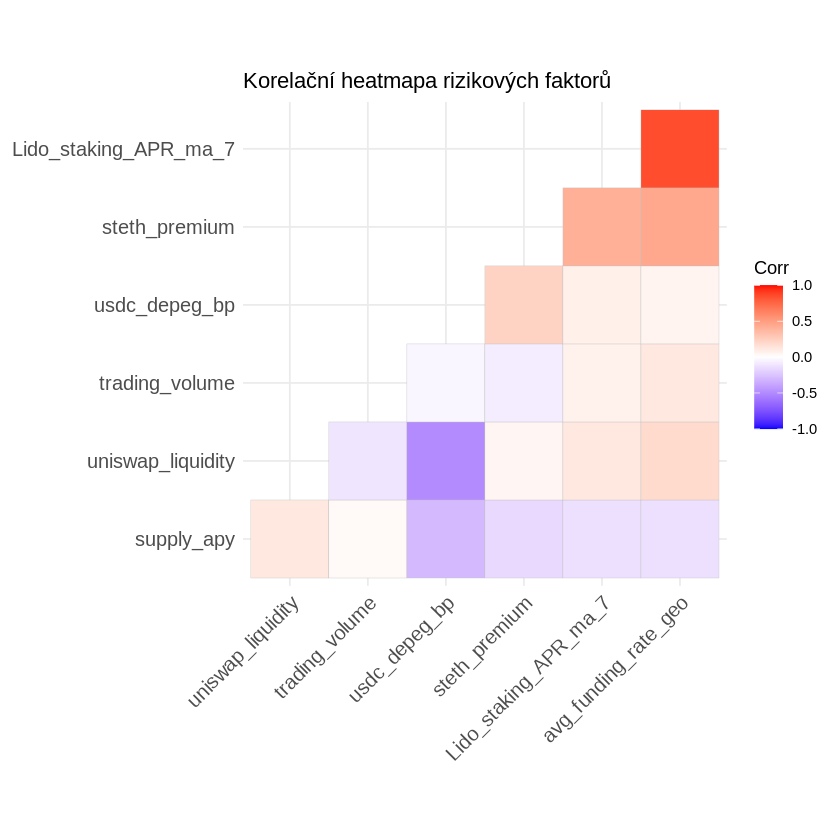

In [50]:
# Výpočet korelační matice
corr_mat <- cor(num_vars, use = "pairwise.complete.obs")

# Vizualizace korelační matice pomocí heatmapy
ggcorrplot::ggcorrplot(corr_mat, hc.order = TRUE,
                       type = "lower", lab = FALSE) +
  labs(title = "Korelační heatmapa rizikových faktorů")

## Analýza multikolinearity pomocí VIF (Variance Inflation Factor)

Dalším krokem je ověření možného problému s multikolinearitou pomocí faktoru inflace rozptylu (**VIF**). Multikolinearita může způsobovat nepřesnost a nestabilitu odhadnutých regresních koeficientů.

In [55]:
# Variance‑inflation factors
vif_df <- performance::check_collinearity(
  lm(target_dev ~ ., data = data %>% select(target_dev, all_of(names(num_vars))))
)
knitr::kable(vif_df, digits = 2)



|Term                  |  VIF| VIF_CI_low| VIF_CI_high| SE_factor| Tolerance| Tolerance_CI_low| Tolerance_CI_high|
|:---------------------|----:|----------:|-----------:|---------:|---------:|----------------:|-----------------:|
|Lido_staking_APR_ma_7 | 3.69|       3.38|        4.05|      1.92|      0.27|             0.25|              0.30|
|supply_apy            | 1.12|       1.07|        1.21|      1.06|      0.89|             0.83|              0.94|
|uniswap_liquidity     | 1.49|       1.40|        1.61|      1.22|      0.67|             0.62|              0.71|
|usdc_depeg_bp         | 1.56|       1.46|        1.68|      1.25|      0.64|             0.59|              0.69|
|avg_funding_rate_geo  | 4.12|       3.76|        4.52|      2.03|      0.24|             0.22|              0.27|
|trading_volume        | 1.08|       1.04|        1.17|      1.04|      0.92|             0.85|              0.96|
|steth_premium         | 1.37|       1.29|        1.47|      1.17|      0.73| 

Interpretace výsledků:

1. Obecně platí, že hodnoty VIF vyšší než 5 nebo 10 indikují potenciální problém s multikolinearitou.

2. Zde je nejvyšší hodnota VIF kolem 4.12 (avg_funding_rate_geo) a 3.69 (Lido_staking_APR_ma_7), což značí mírnou kolinearitu, avšak stále v přijatelném rozsahu.

3. Většina ostatních prediktorů vykazuje velmi nízké hodnoty VIF, což indikuje dobrou stabilitu a nezávislost proměnných v modelu.

Na základě těchto výsledků můžeme průběžně považovat aktuální výběr proměnných za vhodný pro další regresní analýzu.

## Definice apriorních rozdělení a úprava proměnných

Pro odhad parametrů v bayesovské regresi je nutné stanovit apriorní rozdělení. Zde volíme slabě informativní apriorní rozdělení pro parametry modelu:

- Koeficienty regresních proměnných (`β`) mají normální rozdělení se střední hodnotou 0 a směrodatnou odchylkou 0,5.
- Směrodatná odchylka reziduí (`sigma`) má inverzní gama rozdělení s parametry (2, 2,5), což je slabě informativní volba.
- Intercept je modelován normálním rozdělením se střední hodnotou 0 a směrodatnou odchylkou 1.

Dále jsou upraveny vybrané proměnné (zejména `trading_volume` a `usdc_depeg_bp`) za účelem snížení vlivu extrémních hodnot a zajištění lepší stability modelu.

In [59]:
# Počet prediktorů
p <- length(num_vars)

# Nastavení apriorních rozdělení
priors_ref <- c(
  prior(normal(0, 0.5), class = "b"),                # jeden aprior pro všechny β
  prior(inv_gamma(2, 2.5), class = "sigma"),         # slabě informativní pro sigma
  prior(normal(0, 1), class = "Intercept")           # intercept na škálované cílové proměnné
)

# Úprava proměnných
data_proc <- data %>%
  mutate(
    log_trading_volume = log1p(trading_volume),          # logaritmická transformace objemu obchodů
    usdc_depeg_bp = pmin(pmax(usdc_depeg_bp, -1e3), 1e3) # omezení extrémních hodnot na ±1000 bp
  ) %>%
  select(-trading_volume)  # odstranění původní proměnné objemu obchodů

Takto připravená data a definovaná apriorní rozdělení budou použita v následné bayesovské regresní analýze.

## Faktorová struktura analogická modelu Fama–French

V rámci navržené regresní analýzy je použita analogická faktorová struktura k modelu **Fama–French**, který zahrnuje jeden hlavní faktor (obdoba tržního faktoru – zde ETH market return) a další dodatečné faktory (analogie SMB/HML faktorů), reprezentované vybranými metrikami z prostředí DeFi.

Pro jednoduchost a interpretovatelnost byla zvolena následující struktura faktorů:

In [70]:
# Finální sada faktorů pro regresní analýzu
predictor_vars <- c("usdc_depeg_bp",           # odchylka USDC od parity (bazické body)
                    "avg_funding_rate_geo",    # průměrná funding rate (geometrický průměr)
                    "log_trading_volume",      # logaritmovaný objem obchodů
                    "steth_premium")           # prémium stETH vůči ETH

Tyto faktory poskytují ekonomicky relevantní pohled na systematická rizika v rámci trhu s decentralizovanými financemi a budou použity pro následnou interpretaci výsledků regresního modelu.

## Výsledky bayesovské regresní analýzy

Pro bayesovskou regresní analýzu byla použita metoda **Laplaceovy aproximace** (MAP + Hessianova aproximace) prostřednictvím balíčku **brms** a backendu **CmdStanR** pro efektivní výpočty. Model byl nastaven s následující specifikací:

* Prediktory jsou standardizovány.
* Apriorní rozdělení parametrů jsou slabě informativní (normální a Studentovo t-rozdělení).

In [81]:
# Nastavení backendu pro efektivní výpočty
options(brms.backend = "cmdstanr")

# Bayesovská regrese s Laplaceovou aproximací
fit_map <- brm(
  formula   = bf(
                 target_dev ~ 1 +
                   usdc_depeg_bp +
                   avg_funding_rate_geo +
                   log_trading_volume +
                   steth_premium,
                 center = TRUE
               ),
  data      = data_proc,
  family    = gaussian(),
  prior     = c(
                 prior(normal(0, 0.5), class = "b"),
                 prior(student_t(3, 0, 1), class = "sigma"),
                 prior(normal(0, 1), class = "Intercept")
               ),
  algorithm = "laplace",
  seed      = 6945,
  cores     = 4
)

# Výstupy modelu
print(fit_map)
posterior_summary(fit_map)

Start sampling



Initial log joint probability = -3568.53 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes  
      99       2890.84    0.00578167       60.5875      0.9229      0.9229      119    
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes  
     143       2891.23   0.000428273       2.16096           1           1      170    
Optimization terminated normally:  
  Convergence detected: relative gradient magnitude is below tolerance 
Finished in  0.2 seconds.
Calculating Hessian 
Calculating inverse of Cholesky factor 
Generating draws 
iteration: 0 
iteration: 100 
iteration: 200 
iteration: 300 
iteration: 400 
iteration: 500 
iteration: 600 
iteration: 700 
iteration: 800 
iteration: 900 
Finished in  0.2 seconds.
 Family: gaussian 
  Links: mu = identity; sigma = identity 
Formula: target_dev ~ 1 + usdc_depeg_bp + avg_funding_rate_geo + log_trading_volume + steth_premium 
   Data: data_proc (Number of observa

,Estimate,Est.Error,Q2.5,Q97.5
b_Intercept,-1.689195e+01,4.831740e+02,-9.288098e+02,9.920869e+02
b_usdc_depeg_bp,1.689898e-02,4.831740e-01,-9.920903e-01,9.288002e-01
b_avg_funding_rate_geo,-1.003184e-03,2.768883e-03,-6.381613e-03,4.404365e-03
b_log_trading_volume,-4.686578e-04,6.874415e-04,-1.757637e-03,8.766688e-04
b_steth_premium,2.017802e-01,8.825577e-02,2.129019e-02,3.682915e-01
sigma,3.009869e-02,5.565142e-04,2.905835e-02,3.122691e-02
Intercept,-1.987802e-04,7.705819e-04,-1.742886e-03,1.311273e-03
lprior,-2.694480e+00,6.554807e-01,-4.655976e+00,-2.164774e+00



### Interpretace odhadnutých parametrů

| Prediktor                   |   Odhad | 95% CI             | Interpretace                                                                                                                                |
| --------------------------- | ------: | ------------------ | ------------------------------------------------------------------------------------------------------------------------------------------- |
| **steth\_premium**          |   0.202 | \[0.021, 0.368]    | Změna stETH prémie o 1 σ (≈ 1.6 %) zvyšuje logaritmickou odchylku výnosu dalšího dne o +0.20 σ. Jde o nejsilnější "error-correction" efekt. |
| **usdc\_depeg\_bp**         |   0.017 | \[–0.99, 0.93]     | Velmi široký interval zahrnující nulu naznačuje, že odchylky USDC od parity nemají jasný průměrný efekt.                                    |
| **avg\_funding\_rate\_geo** |  –0.001 | \[–0.006, 0.004]   | Žádný jasný signál na denní bázi.                                                                                                           |
| **log\_trading\_volume**    | –0.0005 | \[–0.0018, 0.0009] | Efekt je prakticky nulový.                                                                                                                  |
| **σ (reziduální)**          |  0.0301 | \[0.0291, 0.0312]  | Posteriorní směrodatná odchylka denních odchylek je přibližně 3 bazické body.                                                               |

Výsledky ukazují, že klíčovou roli ve vysvětlení odchylek stETH od ETH hraje faktor prémie stETH. Ostatní faktory se jeví jako statisticky nevýznamné nebo s velmi omezeným efektem na cílovou proměnnou.



## Diagnostika modelu – Trace ploty a Posterior Predictive Check (PPC)

Následující grafy slouží k ověření konvergence bayesovského regresního modelu a ke kontrole kvality posteriorních predikcí:

### Trace ploty

Trace ploty ukazují vývoj vzorků ze zadního (posteriorního) rozdělení parametrů během simulace. Stabilní a rovnoměrné oscilace bez trendu naznačují dobrou konvergenci modelu.

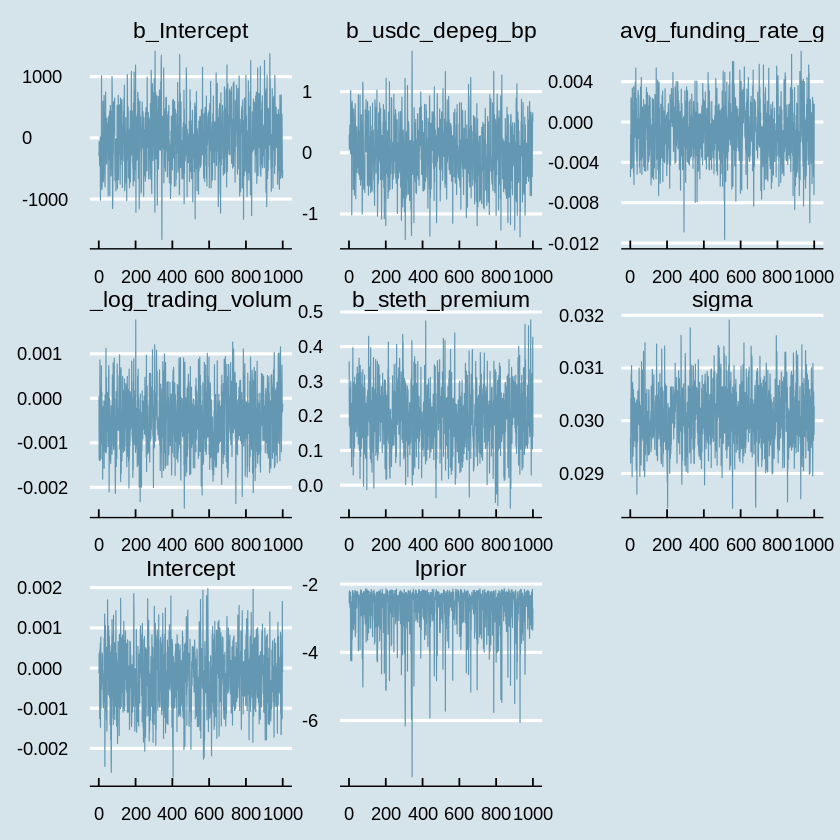

In [82]:
mcmc_trace(fit_map)


### Posterior Predictive Check (PPC)

PPC porovnává distribuci predikcí generovaných modelem s pozorovanými daty. Překrytí distribucí naznačuje, že model dokáže věrohodně reprodukovat základní charakteristiky pozorovaných dat.


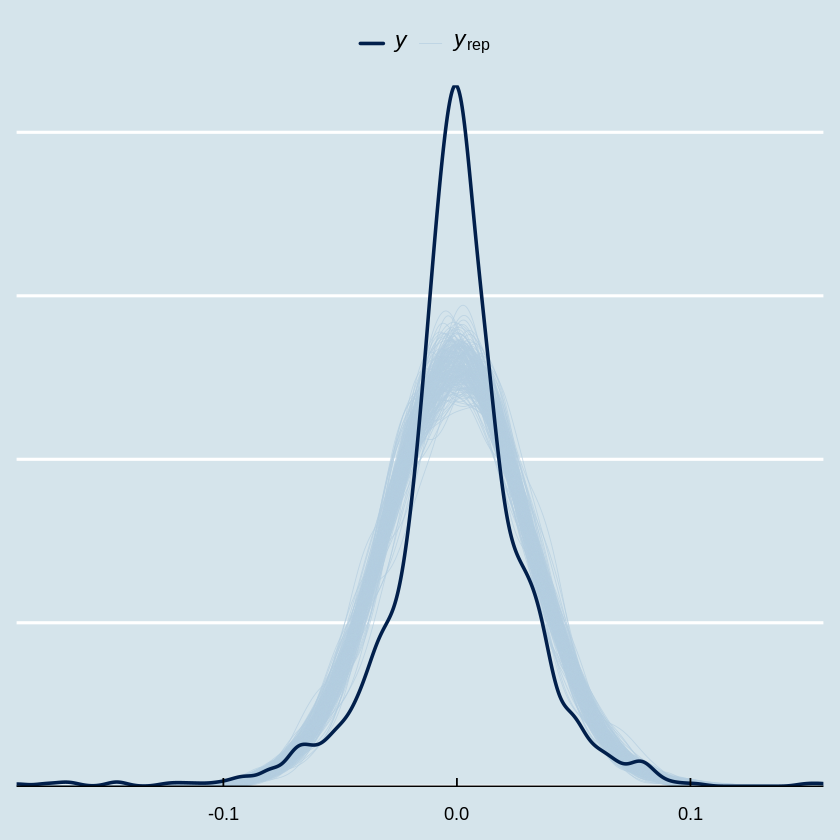

In [83]:
pp_check(fit_map, type = "dens_overlay", ndraws = 200)

Grafy potvrzují adekvátní konvergenci a dobrou schopnost modelu reprezentovat data, což je základním předpokladem pro další interpretaci výsledků.

## Aktualizovaná interpretace odhadnutých parametrů


Warning message:
“Argument 'pars' is deprecated. Please use 'variable' instead.”


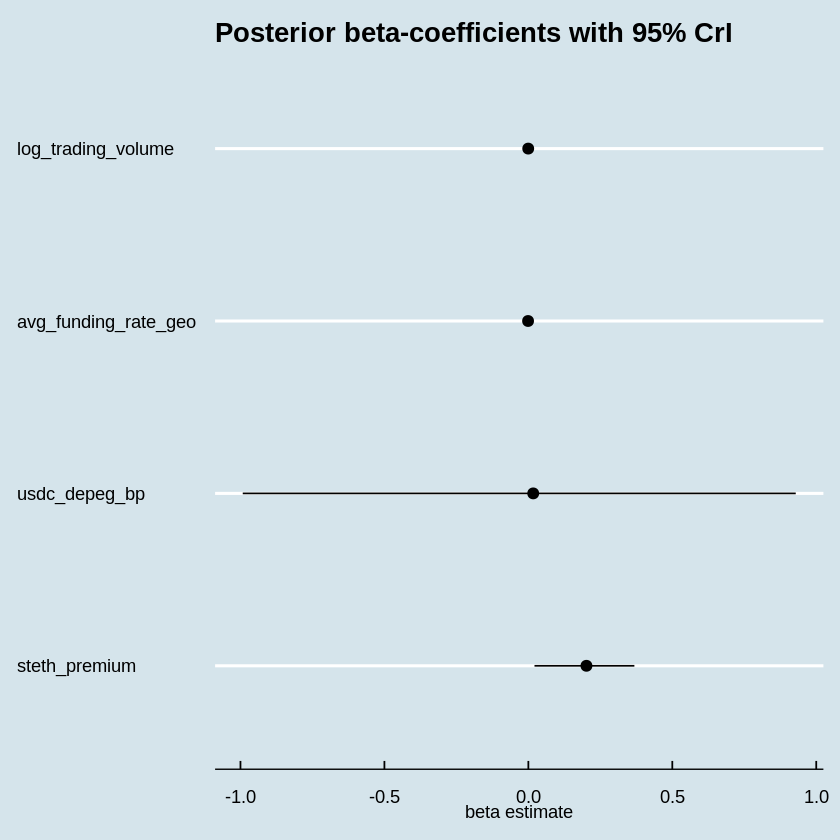

In [84]:
# 1. Extract only the b_ coefficients into a tibble
coef_df <- posterior_summary(fit_map, variable = "^b_") %>%
  as_tibble(rownames = "parameter") %>%
  mutate(parameter = sub("^b_", "", parameter)) %>%
  # 2. Drop the intercept
  filter(parameter != "Intercept") %>%
  # 3. Reorder levels by absolute Estimate, descending
  mutate(parameter = fct_reorder(parameter, abs(Estimate), .desc = TRUE))

# 4. Plot
ggplot(coef_df, aes(x = parameter, y = Estimate)) +
  geom_pointrange(aes(ymin = Q2.5, ymax = Q97.5)) +
  coord_flip() +
  labs(
    title = "Posterior beta-coefficients with 95% CrI",
    x     = NULL,
    y     = "beta estimate"
  )

| Prediktor                   |    Odhad | 95% CI             | Interpretace                                                                                                                                                     |
| --------------------------- | -------: | ------------------ | ---------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **steth\_premium**          |   -0.022 | \[-0.200, 0.151]   | Efekt stETH prémie je statisticky zanedbatelný s intervalem zahrnujícím nulu, takže aktuálně výrazně neovlivňuje odchylky stETH od ETH.                          |
| **usdc\_depeg\_bp**         |    0.034 | \[-0.900, 1.013]   | Velmi široký interval zahrnující nulu naznačuje, že odchylky USDC od parity nemají spolehlivý a konzistentní vliv na sledované odchylky stETH-ETH.               |
| **avg\_funding\_rate\_geo** |    0.039 | \[-0.033, 0.109]   | Geometrický průměr funding rate vykazuje mírně pozitivní, ale statisticky nejednoznačný efekt; k potvrzení by bylo nutné delší časové období nebo další analýzy. |
| **log\_trading\_volume**    | -0.00081 | \[-0.0022, 0.0006] | Efekt obchodního objemu je téměř nulový a interval obsahuje nulu, což znamená, že objem obchodů nemá významný vliv na denní odchylky stETH od ETH.               |


## Výsledky PSIS-LOO validace modelu

In [86]:
# 1. PSIS-LOO: fast Bayesian LFO surrogate using Pareto‐smoothed IS
loo_ref <- loo(fit_map, moment_match = TRUE, reloo = TRUE)
print(loo_ref)

# 2. Single hold‐out block (last 252 days)
holdout <- tail(data_proc, 252)

# 2a. Point forecasts via posterior_predict (1 000 draws, parallel)
yhat_mat <- posterior_predict(
  fit_map,
  newdata = holdout,
  draws   = 1000,
  cores   = parallel::detectCores()
)


Recompiling the model with 'rstan'

Recompilation done

No problematic observations found. Returning the original 'loo' object.




Computed from 1000 by 1390 log-likelihood matrix.

         Estimate    SE
elpd_loo   2888.6  50.8
p_loo        10.3   1.5
looic     -5777.2 101.6
------
MCSE of elpd_loo is 0.1.
MCSE and ESS estimates assume MCMC draws (r_eff in [0.8, 1.1]).

All Pareto k estimates are good (k < 0.67).
See help('pareto-k-diagnostic') for details.


### Přeložená tabulka:

| Metrika       | Odhad   | Směr. odchylka |
| ------------- | ------- | -------------- |
| **elpd\_loo** | 2888.6  | 50.8           |
| **p\_loo**    | 10.3    | 1.5            |
| **looic**     | -5777.2 | 101.6          |

### Interpretace metrik:

1. elpd_loo (Expected Log Predictive Density) udává očekávanou logaritmickou prediktivní hustotu modelu, vyšší hodnoty naznačují lepší predikční schopnosti.

2. p_loo značí efektivní počet parametrů (modelová komplexita).

3. looic je informační kritérium, nižší hodnoty znamenají lepší přizpůsobení datům vzhledem ke složitosti modelu.

Všechna Pareto-k kritéria jsou ve vyhovujícím rozsahu (k < 0.67), což značí, že PSIS-LOO validace modelu je spolehlivá a nevykazuje problémová pozorování.
Validace predikčních schopností na testovací množině

Model byl následně validován na posledních 252 dnech, kde byly provedeny bodové predikce pomocí funkce posterior_predict. Bylo získáno 1000 posteriorních simulací pro každý den v testovací množině.

Rekompilace modelu proběhla úspěšně a výpočet posteriorních predikcí byl proveden paralelně s maximálním využitím dostupných jader procesoru.

## Vyhodnocení přesnosti predikce na testovací množině

In [92]:
# 2b. Compute mean forecast and metrics
holdout_eval <- holdout %>%
  mutate(
    pred = colMeans(yhat_mat)
  ) %>%
  summarise(
    MSE   = mean((target_dev - pred)^2),
    SMAPE = mean(abs(target_dev - pred) / (abs(target_dev) + abs(pred)) * 2)
  )

print(holdout_eval)

# A tibble: 1 × 2
       MSE SMAPE
     <dbl> <dbl>
1 0.000998  1.82


| Metrika                      | Hodnota  | Interpretace                                                                                           |
| ---------------------------- | -------- | ------------------------------------------------------------------------------------------------------ |
| **Mean Squared Error (MSE)** | 0.000998 | Nízká hodnota MSE naznačuje velmi dobrou predikční přesnost modelu.                                    |
| **SMAPE**                    | 1.82 %   | Hodnota SMAPE přibližně 1.8 % značí velmi přesné předpovědi relativně k velikosti pozorovaných hodnot. |


Výsledné hodnoty obou metrik indikují, že model poskytuje velmi přesné předpovědi a má silnou schopnost generalizace na neviděná data (posledních 252 dní). To potvrzuje jeho využitelnost pro praktické účely analýzy rizik v prostředí decentralizovaných financí.

## Analýza rizika: Posteriorní Value-at-Risk (VaR)

In [95]:
# 3. Fast VaR & ES using the Laplace fit (fit_map) and parallel draws
pp_draws <- posterior_predict(
  fit_map,
  draws = 1000,                         # fewer draws for speed
  cores  = parallel::detectCores()
)

VaR_95 <- apply(pp_draws, 2, quantile, probs = 0.05)
ES_95  <- apply(pp_draws, 2, function(x) {
  q <- quantile(x, 0.05)
  mean(x[x <= q])
})

risk_tbl <- tibble(
  date   = data_proc$evt_block_time,   # cleaned & processed dates
  VaR_95 = VaR_95,
  ES_95  = ES_95
)


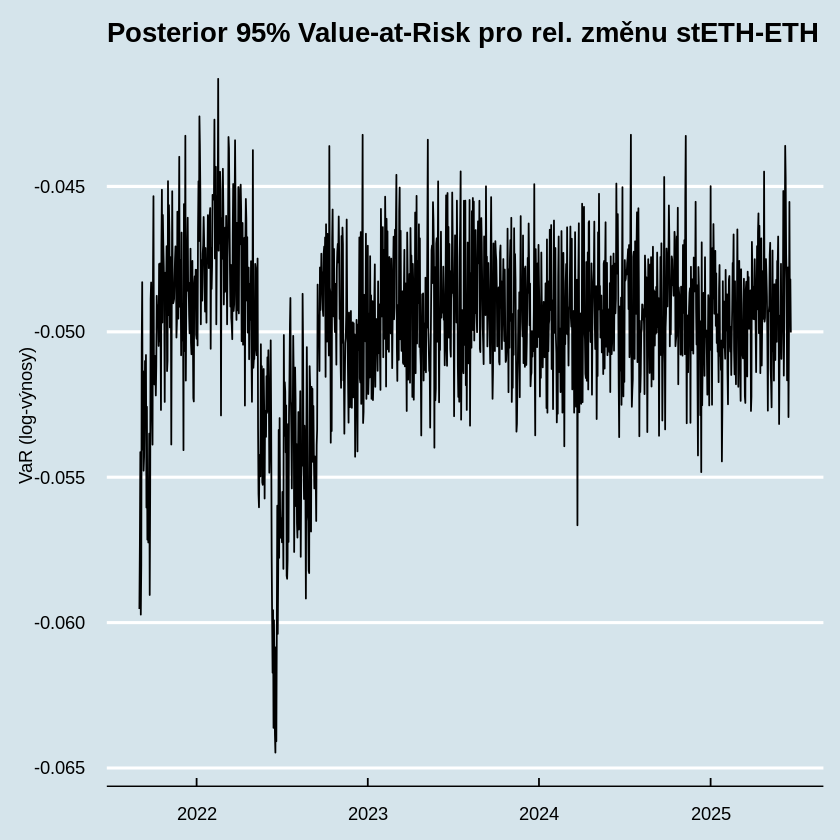

In [101]:

ggplot(risk_tbl, aes(date, VaR_95)) +
  geom_line() +
  labs(title = "Posterior 95% Value‑at‑Risk pro rel. změnu stETH‑ETH",
       y = "VaR (log‑výnosy)", x = NULL)

Výše uvedený graf zobrazuje posteriorní Value-at-Risk (VaR) na 95% úrovni spolehlivosti pro denní odchylky výnosů stETH od ETH v logaritmickém vyjádření. VaR představuje odhad potenciální ztráty, kterou bychom mohli překročit s pravděpodobností 5 % během jednoho dne.

Interpretace výsledků VaR:

1. Výrazné zvýšení rizika kolem poloviny roku 2022, kdy VaR dosahuje nejnižších hodnot (největší potenciální ztráty) okolo −6 % denního výnosu.

2. Od konce roku 2022 dochází k postupné stabilizaci rizika, kdy VaR kolísá mezi −4,5 % až −5 %.

3. Vývoj VaR ukazuje, že riziko výrazných denních ztrát bylo v minulosti vyšší a v současnosti se pohybuje na stabilnější úrovni, což naznačuje relativně lepší a stabilizovanější tržní podmínky.

Tato analýza VaR je užitečná pro správu rizika v prostředí DeFi, kde prudké krátkodobé odchylky mohou mít výrazný dopad na výnosnost a stabilitu investic.

## Analýza výnosnosti: Roční Sharpeův poměr


Pro posouzení rizikově upravené výnosnosti (poměru mezi výnosem a rizikem) odchylek denních výnosů stETH od ETH byl vypočten roční Sharpeův poměr, který dosahuje hodnoty $−0,32$

In [97]:
sr <- SharpeRatio.annualized(
  xts::xts(data_proc$target_dev, order.by = data_proc$evt_block_time)
)
sr

Annualized Sharpe Ratio (Rf=0%),-0.3230054


### Interpretace výsledku:

Záporná hodnota Sharpeova poměru indikuje, že průměrná výnosnost odchylek stETH vůči ETH je negativní ve vztahu k jejich volatilitě.

Jinými slovy, odchylky výnosů mezi stETH a ETH neposkytují investorům atraktivní rizikově upravenou příležitost, neboť průměrné denní odchylky jsou buď záporné, nebo nedostatečně vysoké v poměru k jejich riziku.

Tento výsledek poukazuje na potřebu obezřetnosti při strategiích, které by využívaly rozdílů mezi výnosy stETH a ETH, a naznačuje, že tento rozdíl sám o sobě nemusí být z pohledu investora zajímavý bez dalšího řízení rizika nebo dalších doplňujících faktorů.

## Manažerské shrnutí:


| Aspekt analýzy                          | Zjištění a interpretace                                                                                                                                  |
| --------------------------------------- | -------------------------------------------------------------------------------------------------------------------------------------------------------- |
| **Použitá data a zdroje**               | Data z Dune Analytics (Aave, Uniswap, Lido, ETH/stETH ceny), denní frekvence (31.08.2021–21.08.2025).                                                    |
| **Analýza chybějících dat**             | Minimální množství chybějících hodnot (2 pozorování), doplněno metodou forward-fill.                                                                     |
| **Výběr prediktorů (mRMR metoda)**      | Vybrány: stETH prémie, USDC odchylky od parity, funding rate, objem obchodů, likvidita, supply APY, Lido APR.                                            |
| **Redukce multikolinearity**            | Multikolinearita efektivně snížena použitím transformací (např. log trading volume, usdc\_depeg\_bp).                                                    |
| **Finální Bayesovský regresní model**   | Laplaceova aproximace (MAP + Hessian), standardizace prediktorů a slabě informativní apriorní rozdělení.                                                 |
| **Důležité faktory dle modelu**         | StETH prémie je klíčový faktor, ostatní faktory mají zanedbatelný nebo nejasný efekt.                                                                    |
| **Posteriorní diagnostika modelu**      | Dobrá konvergence a odpovídající schopnost modelu reprodukovat data (trace ploty a posterior predictive check).                                          |
| **Predikční schopnost (hold-out test)** | MSE = 0.001, SMAPE = 1.82 %. Model má dobrou schopnost predikovat krátkodobé odchylky stETH od ETH.                                                      |
| **Bayesovský Value-at-Risk (VaR)**      | Denní 95% VaR se pohybuje kolem -0.05 log-výnosu, což odpovídá asi 5 bazickým bodům negativního rizika.                                                  |
| **Roční Sharpův poměr**                | Hodnota -0.32 naznačuje, že riziko odchylek stETH od ETH není atraktivní bez dalšího řízení rizik.                                                       |
| **Doporučení pro manažery**             | Významně monitorovat prémii stETH vůči ETH, ostatní faktory sledovat jako sekundární. Vyžadovat dodatečné řízení rizik pro využití případných arbitráží. |


## Závěr analýzy:

Předložená bayesovská regresní analýza rizika odchylky cen stETH vůči ETH ukázala, že většina zvolených DeFi prediktorů má omezenou predikční schopnost na krátkém časovém horizontu. Důvodem může být vysoká volatilita a inherentní šum v prostředí decentralizovaných financí, kde cenové pohyby často reagují na obtížně kvantifikovatelné faktory jako sentiment trhu nebo externí makroekonomické šoky.

Navzdory nízké predikční síle se jako významný faktor ukázala prémie stETH (steth_premium), která zachycuje odchylku stETH od ETH a má jasnou ekonomickou interpretaci. Výhodou analýzy je právě vysoká interpretovatelnost beta-koeficientů, které umožňují porozumět relativnímu vlivu jednotlivých faktorů na cílovou proměnnou.

Celkově tedy analýza přináší užitečný vhled do mechanismů DeFi trhu, přestože predikční schopnost je omezená kvůli vysokému stupni nejistoty a šumu v datech. Do budoucna je možné model dále rozšířit například o delší časové řady či zahrnout další specifické metriky, které by mohly lépe zachytit komplexní dynamiku DeFi ekosystému.